In [202]:
import datetime

import pandas as pd
import spacy
import re
import string
import numpy as np

import seaborn as sns
from matplotlib import cm
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
%matplotlib inline

from spacy.tokens import Token
from tqdm import tqdm
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import gensim
from gensim import corpora, models
from gensim.models.phrases import Phrases, Phraser
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim.models.coherencemodel import CoherenceModel
from gensim.models import HdpModel

from sklearn import metrics
from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter
import itertools

import pyLDAvis.gensim
pyLDAvis.enable_notebook()
from ipywidgets import interact

import nltk
from nltk.corpus import stopwords
from textblob import TextBlob

from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans

from sklearn.metrics import silhouette_score

import enchant
pd.set_option('display.max_rows', 500)

In [2]:
dict_check = enchant.Dict("en_US")

#### Importing the file ####
Path="src/"
Filename='projects_Preprocessed.csv'
df=pd.read_csv(Path+Filename)

Cat_File="category_hier.csv"
Cat_data=pd.read_csv(Path+Cat_File)

varcluster_file="variable_clusters.csv"
varcluster=pd.read_csv(Path+varcluster_file)

manualtag=pd.read_csv(Path+'SamplesManualTagger.csv')
varcluster_info=pd.read_csv(Path+'variable_clusters_info_v2.csv')

df=df[df['Translates']!="The goal of the Heisenberg Program is to enable outstanding scientists who fulfill all the requirements for a long-term professorship to prepare for a scientific leadership role and to work on further research topics during this time. In pursuing this goal, it is not always necessary to choose and implement project-based procedures. For this reason, in the submission of applications and later in the preparation of final reports - unlike other support instruments - no 'summary' of project descriptions and project results is required. Thus, such information is not provided in GEPRIS."]

## Filtering the null abstracts & short description
df=df[(pd.isnull(df.PreProcessedDescription)==False) & (df.PreProcessedDescription.str.strip()!='abstract available')& (df.PreProcessedDescription.str.len()>100) & (pd.isnull(df["SubjectArea"])==False)]

# Striping the category column
Cat_data.Category=Cat_data.Category.str.strip()

## Merging the high level category information

df=df.merge(Cat_data[["File_Categories","Category"]], how="left", left_on="SubjectArea", right_on="File_Categories")

dbdf=pd.read_csv(Path+'Report_WEPCADBScanFindingsKMeansV3.csv')

In [307]:
Cat_data.sort_values('Category')

,File_Categories,Level 3 Matching,Level 2 Matching,Level 1 Matching,Manual Match,Category
137,Primary Shaping and Reshaping Technology,Engineering Sciences,NaN,NaN,NaN,Engineering Sciences
219,Biological Process Engineering,Engineering Sciences,NaN,NaN,NaN,Engineering Sciences
37,Systems Engineering,NaN,Engineering Sciences,NaN,NaN,Engineering Sciences
218,Energy Process Engineering,Engineering Sciences,NaN,NaN,NaN,Engineering Sciences
128,"Architecture, Building and Construction Histor...",Engineering Sciences,NaN,NaN,NaN,Engineering Sciences
129,"Operating, Communication, Database and Distrib...",Engineering Sciences,NaN,NaN,NaN,Engineering Sciences
130,Software Engineering and Programming Languages,Engineering Sciences,NaN,NaN,NaN,Engineering Sciences
211,"Artificial Intelligence, Image and Language Pr...",NaN,NaN,NaN,Engineering Sciences,Engineering Sciences
206,Mechanical and Industrial Engineering,NaN,NaN,NaN,Engineering Sciences,Engineering Sciences
205,"Engineering Design, Machine Elements, Product ...",Engineering Sciences,NaN,NaN,NaN,Engineering Sciences


In [3]:
## Only keeping noun and adjective

df.PreProcessedDescription=df.PreProcessedDescription.apply(lambda x : ' '.join([i for i,pos in TextBlob(x).tags if pos in ['NN','JJ']]))

In [4]:
manualstopwords=['research','group','subject','process','development','analysis','model','different','new','process','study','change','system','approach', 'phase', 'high', 'develop', 'allow','investigation','property','interaction','university', 'device', 'institute', 'researcher', 'science', 'fund', 'facility', 'coordination', 'cooperation']

In [5]:
varcluster_info.cluster_id=varcluster_info.cluster_id.astype('int32')
varclusterall=varcluster.merge(varcluster_info, how='left',left_on='Cluster', right_on='cluster_id')
newstopwords=varclusterall[(varclusterall.cluster_name=='General') | (varclusterall.cluster_name=='Text & Publish') ].Variable.tolist()+manualstopwords
#.sort_values(by='RS_Ratio')

In [6]:
df.PreProcessedDescription=[' '.join([words for words in abstract.split() if(not words in newstopwords)]) for abstract in df.PreProcessedDescription ]

### Preprocessing 

In [7]:
# TF IDF Conversion

vectorizer = TfidfVectorizer(max_features=1000, ngram_range=(1, 2))
review_vectors = vectorizer.fit_transform(df["PreProcessedDescription"])
features_df = pd.DataFrame(review_vectors.toarray(), columns = vectorizer.get_feature_names())

features_df.reset_index(drop=True, inplace=True)
df.reset_index(drop=True, inplace=True)
merged_data=pd.concat([df,features_df], axis=1,ignore_index=False)

#wordslist=merged_data.columns.tolist()[len(df.columns)+6:]

In [293]:
#https://gepris.dfg.de/gepris/projekt/252374284

merged_data[merged_data.SubUrl=='/gepris/projekt/252374284'].Name.values[0]

'Wayfinding Through Orientation (WayTO): Support for Spatial Orientation and Wayfinding in Real Environments Through Cognitively Appropriate Spatial Information Provided by Mobile Navigation Assistance '

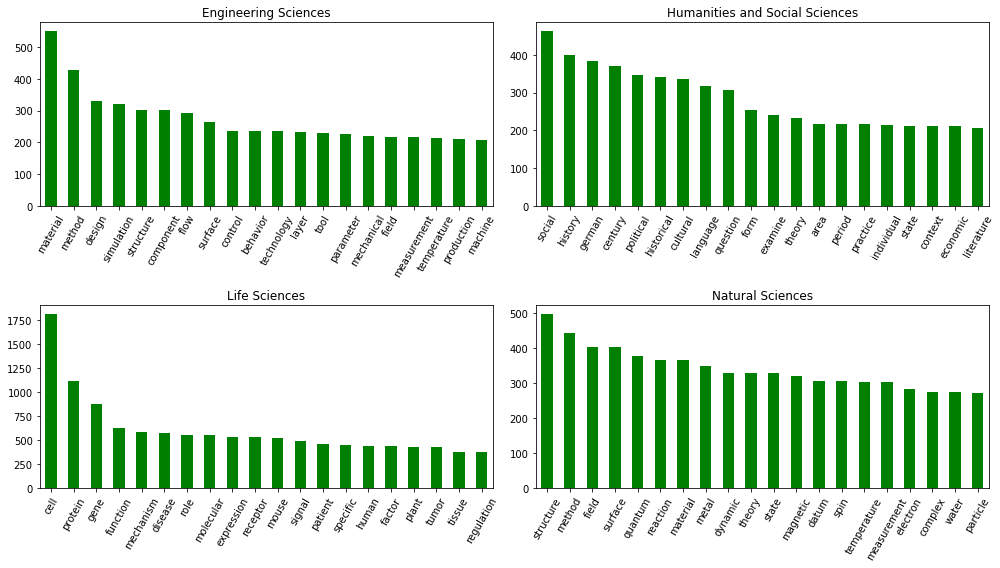

In [8]:
wordslist=merged_data.columns.tolist()[len(df.columns)+2:]

plt.subplots(figsize=(14,8)) 
i=1
categories=[]
category_words=[]

for cat,bucket in merged_data.groupby('Category'):
    
    plt.subplot(2,2,i)
    bucket[wordslist].sum().sort_values(ascending=False).head(20).plot(kind='bar',color='green')
    plt.title(cat)
    plt.xticks(rotation=60)
    i=i+1
    plt.tight_layout()
    categories.append(cat)
    category_words.append( ' '.join(bucket[wordslist].sum().sort_values(ascending=False).head(50).index.tolist()))

CategoryImpoWords=pd.DataFrame({'Category':categories,'Words':category_words})

In [9]:
CategoryImpoWords.Words.tolist()

['material method design simulation structure component flow surface control behavior technology layer tool parameter mechanical field measurement temperature production machine influence datum particle test order problem use stress possible numerical experimental condition increase load alloy optimization technique dynamic network quality large area form sensor element concept measure performance algorithm low',
 'social history german century political historical cultural language question form examine theory area period practice individual state context economic literature hand law focus policy early european concept literary knowledge germany central perspective modern basis religious society culture medium important relationship international discourse national public life collection order manuscript market datum',
 'cell protein gene function mechanism disease role molecular expression receptor mouse signal patient specific human factor plant tumor tissue regulation response acti

In [10]:
CategoryImpoWords.loc[CategoryImpoWords.Category=='Engineering Sciences', 'Words']='engineer method simulation component flow surface behavior technology tool parameter mechanical field measurement temperature production machine particle numerical optimization technique sensor element measure performance algorithm knowledge'
CategoryImpoWords.loc[CategoryImpoWords.Category=='Humanities and Social Sciences', 'Words']='humanities social history country century political cultural language economic literature law early policy european literary knowledge religious society culture national manuscript market'
CategoryImpoWords.loc[CategoryImpoWords.Category=='Life Sciences', 'Words']='biology life cell protein gene disease molecular receptor mouse signal patient human factor plant tumor tissue membrane immune genetic cellular animal specie dna vivo clinical infection brain therapy inflammatory therapeutic'
CategoryImpoWords.loc[CategoryImpoWords.Category=='Natural Sciences', 'Words']='natural field surface quantum metal theory magnetic spin temperature measurement electron water complex particle energy compound molecule chemical electronic synthesis transition molecular optical climate spectroscopy resolution organic gas polymer sediment'

In [11]:
## Repeated words in category

word=[]
for x in [cc.split() for cc in CategoryImpoWords.Words]:
    word.extend(x)
pd.Series(word).value_counts().sort_values(ascending=False).head(16)#.index.tolist()

molecular      2
particle       2
field          2
knowledge      2
surface        2
temperature    2
measurement    2
method         1
resolution     1
society        1
brain          1
country        1
law            1
compound       1
water          1
algorithm      1
dtype: int64

In [161]:
report1=pd.DataFrame()
for cc in CategoryImpoWords.Category:
    w=pd.Series(CategoryImpoWords.loc[CategoryImpoWords.Category==cc, 'Words'].values[0].split())
    w=w[w.isin(merged_data.columns)].tolist()
    reporter=pd.DataFrame(bucket[w].sum().sort_values(ascending=False)).reset_index()
    reporter['Category']=cc
    report1=pd.concat([report1,reporter], axis=0, ignore_index=False)
    

In [164]:
report1.columns=['words','values','Category']
report1.to_csv(Path+'LDA_TFIDF_Cat.csv', index=False)

#### 1.1 Word Embedding

In [12]:
## Word Embeddings Functions

## Generate the tagged documents (tagging based on the category column)
def create_tagged_document(list_of_list_of_words):
    for i, list_of_words in enumerate(list_of_list_of_words):
        yield gensim.models.doc2vec.TaggedDocument(list_of_words, [i])

## Generate the tagged documents (each record in single tag )
def create_tagged_document_based_on_tags(list_of_list_of_words, tags):
    for i in range(len(list_of_list_of_words)):
        yield gensim.models.doc2vec.TaggedDocument(list_of_list_of_words[i], [tags[i]])

def make_bigram(inputlist):
    bigram = Phrases(inputlist, min_count=3, threshold=1,delimiter=b' ')
    bigram_phraser = Phraser(bigram)
    new_list=[]
    for sent in inputlist:
        new_list.append(bigram_phraser[sent])
    return new_list        
        
## Generate output using the word embedding model prediction - takes long time to regenerate
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs#.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors

In [13]:
## creating a tagged document
#DescDict=make_bigram([[x for x in str(i).split()] for i in df.PreProcessedDescription])
DescDict=[[x for x in str(i).split()] for i in df.PreProcessedDescription]

#tagged_value_tags = list(create_tagged_document_based_on_tags(DescDict, df.Category.tolist()))
tagged_value = list(create_tagged_document(DescDict))

In [14]:
print(str(datetime.datetime.now()),'Started')

# Init the Doc2Vec model
model = gensim.models.Word2Vec(DescDict,size=50, min_count=1, alpha = 0.02, sg=0, seed=42, workers=4)

#### Hyper parameter ####
print(str(datetime.datetime.now()),'Completed')

2020-03-12 20:38:25.768916 Started
2020-03-12 20:39:01.961984 Completed


In [15]:
## Validating the model response for random words 

modelchecked=model
target_word='biology'
print('target_word: %r model: %s similar words:' % (target_word, modelchecked))
for i, (word, sim) in enumerate(modelchecked.wv.most_similar(target_word, topn=10), 1):
    print('    %d. %.2f %r' % (i, sim, word))

target_word: 'biology' model: Word2Vec(vocab=114576, size=50, alpha=0.02) similar words:
    1. 0.86 'biochemistry'
    2. 0.81 'virology'
    3. 0.81 'biophysic'
    4. 0.80 'microbiology'
    5. 0.78 'biologist'
    6. 0.77 'biotechnology'
    7. 0.76 'immunology'
    8. 0.76 'bioscience'
    9. 0.73 'biomedical'
    10. 0.73 'neurobiology'


In [16]:
modelchecked.similarity('country','german')

/Users/balaji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  """Entry point for launching an IPython kernel.


0.7632854

In [17]:
###############################
#### similarity functions #####
###############################

def map_word_frequency(document):
    return Counter(itertools.chain(*document))
    
def get_sif_feature_vectors(sentence1, sentence2, word_emb_model=modelchecked):
    sentence1 = [token for token in sentence1.split() if token in word_emb_model.wv.vocab]
    sentence2 = [token for token in sentence2.split() if token in word_emb_model.wv.vocab]
    word_counts = map_word_frequency((sentence1 + sentence2))
    embedding_size = 50 # size of vectore in word embeddings
    a = 0.0001
    sentence_set=[]
    for sentence in [sentence1, sentence2]:
        vs = np.zeros(embedding_size)
        sentence_length = len(sentence)
        for word in sentence:
            a_value = a / (a + word_counts[word]) # smooth inverse frequency, SIF
            vs = np.add(vs, np.multiply(a_value, word_emb_model.wv[word])) # vs += sif * word_vector
        vs = np.divide(vs, sentence_length) # weighted average
        sentence_set.append(vs)
    return sentence_set

def get_cosine_similarity(feature_vec_1, feature_vec_2):    
    return cosine_similarity(feature_vec_1.reshape(1, -1), feature_vec_2.reshape(1, -1))[0][0]

def similarity_scores(sentence1, sentence2, n=10):
    sentence1=sentence1.replace(',','')
    sentence2=sentence2.replace(',','')
    features=get_sif_feature_vectors(sentence1, sentence2)
    return get_cosine_similarity(features[0][:n],features[1][:n])

### Direct Comparision

In [18]:
direct_score=[]
size=len(df.PreProcessedDescription)
with tqdm(total=size) as bar:
    for i in range(len(df.PreProcessedDescription)):
        topicWord=df.loc[i].PreProcessedDescription
        CatWords=CategoryImpoWords[CategoryImpoWords.Category==df.loc[i].Category].Words.values[0]
        direct_score.append(similarity_scores(topicWord, CatWords,50))
        bar.update(1)

100%|██████████| 51033/51033 [02:33<00:00, 332.22it/s]


In [19]:
df['direct_score']=direct_score

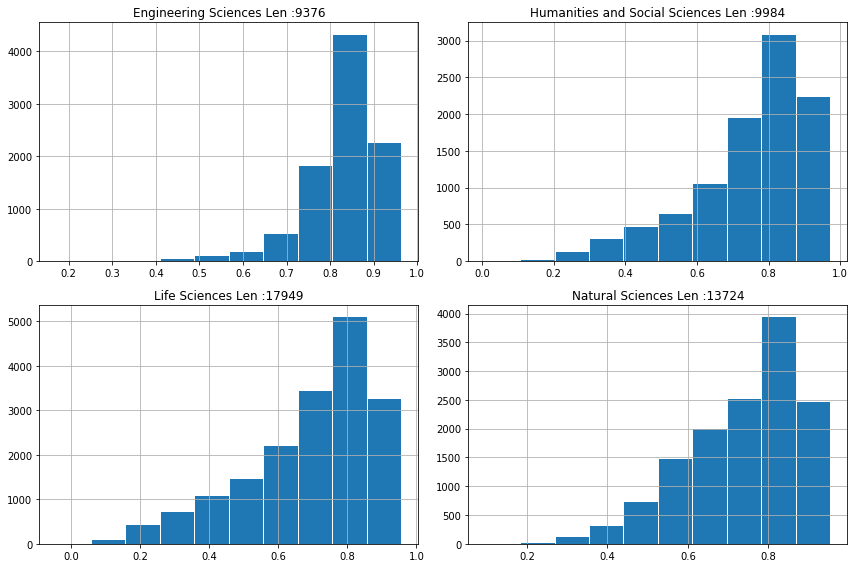

In [20]:
i=1
plt.figure(figsize=(12, 8))
for cc,w in df.groupby(['Category']):
    plt.subplot(2,2,i)
    w['direct_score'].hist( edgecolor='white', linewidth=1)    
    plt.title(str(cc)+' Len :'+str(len(w)))
    i=i+1
plt.tight_layout()

In [21]:
df['ProjectURL']=df.SubUrl.apply(lambda x:'https://gepris.dfg.de'+x)
df1=df.merge(dbdf[['ProjectURL','interdiscipilinary']],how='left', left_on='ProjectURL', right_on='ProjectURL')

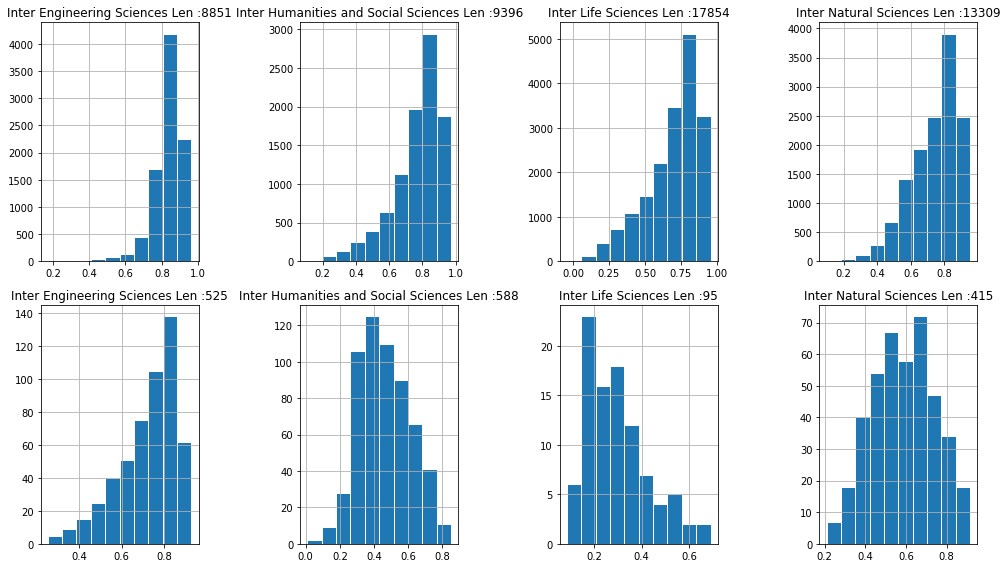

In [22]:
i=1
plt.figure(figsize=(14, 8))
for (intt,cc),w in df1.groupby(['interdiscipilinary','Category']):
    plt.subplot(2,4,i)
    w['direct_score'].hist( edgecolor='white', linewidth=1)    
    plt.title('Inter '+str(cc)+' Len :'+str(len(w)))
    i=i+1
plt.tight_layout()

In [89]:
#limit_cat={'Natural Sciences':.5, 'Humanities and Social Sciences':.58,'Engineering Sciences':0.77, 'Life Sciences':.33}
    limit_cat={'Natural Sciences': 0.5620253164556961,
     'Humanities and Social Sciences': 0.6031645569620252,
     'Engineering Sciences': 0.7677215189873416,
     'Life Sciences': 0.39746835443037976}

df1['new_interdiscipilinary']=False

df1.loc[(df.Category=='Natural Sciences') & (limit_cat['Natural Sciences'] > df1.direct_score)
| (df1.Category=='Humanities and Social Sciences') & (limit_cat['Humanities and Social Sciences'] > df1.direct_score)
| (df1.Category=='Engineering Sciences') & (limit_cat['Engineering Sciences'] > df1.direct_score)
| (df1.Category=='Life Sciences') & (limit_cat['Life Sciences'] > df1.direct_score),'new_interdiscipilinary']=True

#merged_df1[(merged_df1['new_interdiscipilinary'])].Category.value_counts()

In [90]:
df1[(df1['new_interdiscipilinary'])].Category.value_counts()

Humanities and Social Sciences    1772
Natural Sciences                  1758
Life Sciences                     1734
Engineering Sciences              1657
Name: Category, dtype: int64

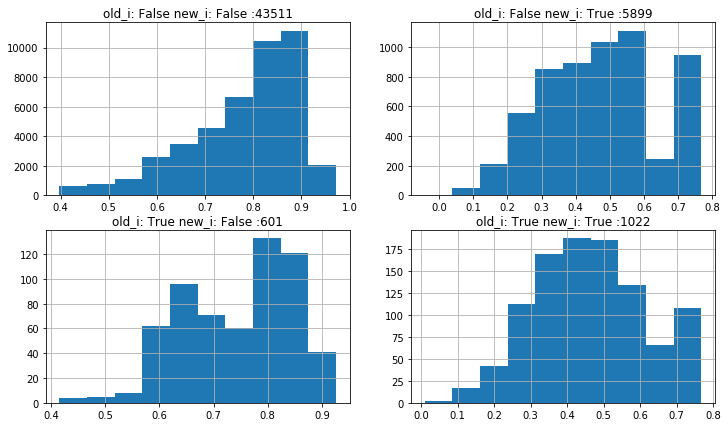

In [91]:
j=1
plt.figure(figsize=(12, 7))
for (old_i,new_i),w in df1.groupby(['interdiscipilinary','new_interdiscipilinary']):
    plt.subplot(2,2,j)
    w['direct_score'].hist()
    plt.title('old_i: '+str(old_i)+' new_i: '+str(new_i)+' :'+str(len(w)) )
    j=j+1

In [92]:
df1[(df1['new_interdiscipilinary']) & (df1['interdiscipilinary']==False) & (df1['Category']=='Life Sciences')].head(10)

,Name,SubUrl,FundingFrom,FundingEnd,SubjectArea,Institution,Description,Translates,Name_Translated,PreProcessedDescription,File_Categories,Category,direct_score,ProjectURL,interdiscipilinary,new_interdiscipilinary
86,GRK 642:&nbsp; Valuation and Management of Bio...,/gepris/projekt/273169,2000,2003,"Agriculture, Forestry and Veterinary Medicine",Georg-August-Universität Göttingen,The goal of the interdisciplinary research tra...,The goal of the interdisciplinary research tra...,GRK 642:&nbsp; Valuation and Management of Bio...,interdisciplinary identify problem perspective...,"Agriculture, Forestry and Veterinary Medicine",Life Sciences,0.220815,https://gepris.dfg.de/gepris/projekt/273169,False,True
102,GRK 721:&nbsp; Evolution and Biodiversity in S...,/gepris/projekt/273327,2002,2004,Fundamental Biological and Medical Research,Rheinische Friedrich-Wilhelms-Universität Bonn,Although every single organism of the biospher...,Although every single organism of the biospher...,GRK 721:&nbsp; Evolution and Biodiversity in S...,single organism shape enormous associate organ...,Fundamental Biological and Medical Research,Life Sciences,0.349225,https://gepris.dfg.de/gepris/projekt/273327,False,True
119,GRK 793:&nbsp; Epidemiology of Communicable an...,/gepris/projekt/273475,2002,2011,Medicine,Ruprecht-Karls-Universität Heidelberg,Large epidemiological studies which have been ...,Large epidemiological studies which have been ...,GRK 793:&nbsp; Epidemiology of Communicable an...,large epidemiological carry design population ...,Medicine,Life Sciences,0.292040,https://gepris.dfg.de/gepris/projekt/273475,False,True
155,GRK 1070:&nbsp; Modelling Material Flows and P...,/gepris/projekt/425187,2004,2013,"Agriculture, Forestry and Veterinary Medicine",Universität Hohenheim,Agricultural food production in the North Chin...,Agricultural food production in the North Chin...,GRK 1070:&nbsp; Modelling Material Flows and P...,agricultural food production north china plain...,"Agriculture, Forestry and Veterinary Medicine",Life Sciences,0.197183,https://gepris.dfg.de/gepris/projekt/425187,False,True
157,GRK 1086:&nbsp; The Role of Biodiversity für B...,/gepris/projekt/446768,2005,2014,Plant Sciences,Georg-August-Universität Göttingen,The relationship between biodiversity and prod...,The relationship between biodiversity and prod...,GRK 1086:&nbsp; The Role of Biodiversity für B...,relationship biodiversity productivity biogeoc...,Plant Sciences,Life Sciences,0.304655,https://gepris.dfg.de/gepris/projekt/446768,False,True
158,GRK 1091:&nbsp; Orientation and Motion in Space,/gepris/projekt/449590,2005,2014,Neurosciences,Ludwig-Maximilians-Universität München,The Research Training Group for system-oriente...,The Research Training Group for system-oriente...,GRK 1091:&nbsp; Orientation and Motion in Space,orient neurobiology discipline faculty ludwig ...,Neurosciences,Life Sciences,0.347927,https://gepris.dfg.de/gepris/projekt/449590,False,True
195,Untersuchungen zum Verhalten von Mastkaninchen...,/gepris/projekt/4981130,1992,2002,"Animal Husbandry, Breeding and Hygiene",Universität Hohenheim,In den vorherigen Untersuchungen haben Kaninch...,"In previous studies, rabbits using operant con...",Studies on the behavior of rabbits under the i...,previous rabbit operant conditioning learn lev...,"Animal Husbandry, Breeding and Hygiene",Life Sciences,0.367854,https://gepris.dfg.de/gepris/projekt/4981130,False,True
196,"Bestimmung der Struktur, Dynamik und Wechselwi...",/gepris/projekt/4992156,1992,2002,Biophysics,University of Strasbourg/CNRS,Unser Ziel sind die Strukturaufklärung der C-t...,Our goal is to elucidate the structure of the ...,"Determination of the structure, dynamics and i...",elucidate structure terminal ion channel colic...,Biophysics,Life Sciences,0.369306,https://gepris.dfg.de/gepris/projekt/4992156,False,True
239,Die Kohlenstoff- und Stickstoffallokation in G...,/gepris/projekt/5076958,1997,2002,Soil Sciences,Rheinische Friedrich-Wilhelms-U

In [27]:
df1[(df1['new_interdiscipilinary']) & (df1['interdiscipilinary']==False) & (df1['Category']=='Life Sciences')].head(10).Translates.tolist()

["The goal of the interdisciplinary research training group is to identify the problems and perspectives of implementation of the biodiversity treaty. The field of research concentrates on areas of conservancy noted in Art. 8 of the treaty. The main starting point is the so-called 'reconciliation of interests' problem describing the phenomenon that costs and benefits for maintaining biodiversity are distributed unequally. Thus, it is necessary for the respective instruments to be developed for just compensation. This dilemma defines the interdisciplinary problem for the research training group and implies its primarily social science orientation.The program of study is tailored to a large degree to the demands of the above mentioned complex of topics. In addition to expanding the intradisciplinary competence of the students, it is especially important to foster the essential to work interdisciplinarily in the scientific and politically relevant area of sustainable development. The comm

In [28]:
df1[(df1['new_interdiscipilinary']) & (df1['interdiscipilinary']==False) & (df1['Category']=='Life Sciences')].head(10).PreProcessedDescription.tolist()

['interdisciplinary identify problem perspective implementation biodiversity treaty field concentrate area conservancy art treaty main point reconciliation interest problem describe phenomenon cost benefit biodiversity distribute respective compensation dilemma interdisciplinary problem training social orientation tailor large degree demand mention complex addition intradisciplinary competence student important foster essential relevant area sustainable commitment treaty educate expert area fulfil form instruction emphasis place element interdisciplinary problem solve train',
 'single organism shape enormous associate organismic evolution relevance evolution unrecognized world view act large scale progress specialisation method deal evolution modern evolutionary matter variety diverge strong training evolution biodiversity space connect aspect evolutionary biology participate field zoology botany molecular developmental biology concern organism palaeontology historical evolution interd

In [29]:
topicWord='biological basis central nervous university institute neurobiology medical faculty otto von guericke university important aspect educational bridge gap clinical basic neuroscience training excellent opportunity young investigator postgraduate level background interest biomedical relate aspect brain disorder broad spectrum integrative combine state art technique interdisciplinary educational lead phd degree md phd successful individual carreer track field brain educate aspect life science magdeburg neuroscience center attract considerable extramural superb facility molecular biochemical modern invasive brain imaging technique student medical faculty leibniz institute neurobiology researcher biology psychology engineering chemistry contribute magdeburgs interdisciplinary neuroscience profile consequence joint effort otto guericke university neuroscience lead diploma master degree science'
for j in CategoryImpoWords.Category:
    CatWords=CategoryImpoWords[CategoryImpoWords.Category==j].Words.values[0]
    score=similarity_scores(topicWord, CatWords,30)
    print(j, score)

Engineering Sciences 0.5604174738873571
Humanities and Social Sciences 0.600783240157536
Life Sciences 0.4130633575951974
Natural Sciences 0.39719041691036977


## Building LDA

In [30]:
###############################
#### LDA Topic Functions #####
###############################

def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(token)
    return result

#def make_bigram(inputlist):
#    bigram = Phrases(inputlist, min_count=1, threshold=1,delimiter=b' ')
#    bigram_phraser = Phraser(bigram)
#    new_list=[]
#    for sent in inputlist:
#        new_list.append(bigram_phraser[sent])
#    return new_list

def buildLDA(processed_docs, ip_num_topics=4):
    dictionary = gensim.corpora.Dictionary(processed_docs)
    dictionary.filter_extremes(no_below=5, no_above=0.1, keep_n=1000)
    bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

    tfidf = models.TfidfModel(bow_corpus)
    corpus_tfidf = tfidf[bow_corpus]
    
    return dictionary,bow_corpus,corpus_tfidf#, lda_model_tfidf

def LDAtopicSummary(model, displaysubplot=[2,2]):
    for idx, topic in model.print_topics(-1):
        print('Topic: {} Word: {}'.format(idx, topic))
        
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list            
        #print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    
    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords',"Text"]
    return(sent_topics_df)

def build_topics_sentences(ldamodel, corpus):
    # Init output
    sent_topics_df = pd.DataFrame()
    out_df=[]
    # Get main topic in each document
    for i, row_list in enumerate(ldamodel.get_document_topics(corpus)):
        row = sorted(row_list, key=lambda x: x[1], reverse=True)
        inn_df=[]
        for num,prob in row:
            inn_df.append(num)
            inn_df.append(prob)
        out_df.append(np.array(inn_df))
            
    return out_df

In [300]:
df[df.Category=='Natural Sciences'].head()

,Name,SubUrl,FundingFrom,FundingEnd,SubjectArea,Institution,Description,Translates,Name_Translated,PreProcessedDescription,File_Categories,Category,direct_score,ProjectURL
0,GRK 6:&nbsp; Spatial Statistics,/gepris/projekt/268853,1997,2003,Mathematics,Technische Universität Bergakademie Freiberg,The work of the research training group is dir...,The work of the research training group is dir...,GRK 6:&nbsp; Spatial Statistics,direct method spatial statistic natural techno...,Mathematics,Natural Sciences,0.523830,https://gepris.dfg.de/gepris/projekt/268853
3,GRK 52:&nbsp; Quantum Field Theory: Mathematic...,/gepris/projekt/269303,1995,2004,Condensed Matter Physics,Universität Leipzig,The aim of the research training group is to p...,The aim of the research training group is to p...,GRK 52:&nbsp; Quantum Field Theory: Mathematic...,pass generation competence leipzig traditional...,Condensed Matter Physics,Natural Sciences,0.780253,https://gepris.dfg.de/gepris/projekt/269303
8,GRK 231:&nbsp; Structure Formation,/gepris/projekt/271009,1996,2004,Mathematics,Universität Bielefeld,The aim of the research training group is to f...,The aim of the research training group is to f...,GRK 231:&nbsp; Structure Formation,interdisciplinary environment observation expl...,Mathematics,Natural Sciences,0.309181,https://gepris.dfg.de/gepris/projekt/271009
10,GRK 243:&nbsp; Nonlinear Differential Equation...,/gepris/projekt/271151,1996,2004,Mathematics,Albert-Ludwigs-Universität Freiburg,Non-linear differential equations play a funda...,Non-linear differential equations play a funda...,GRK 243:&nbsp; Nonlinear Differential Equation...,linear differential equation play fundamental ...,Mathematics,Natural Sciences,0.622878,https://gepris.dfg.de/gepris/projekt/271151
12,GRK 247:&nbsp; Nonlinear Continuous Systems an...,/gepris/projekt/271207,1995,2004,Condensed Matter Physics,Westfälische Wilhelms-Universität Münster,Nonlinear continuous systems are of greatest i...,Nonlinear continuous systems are of greatest i...,GRK 247:&nbsp; Nonlinear Continuous Systems an...,continuous great importance allnature field la...,Condensed Matter Physics,Natural Sciences,0.728272,https://gepris.dfg.de/gepris/projekt/271207


In [31]:


#docs=make_bigram(df["PreProcessedDescription"].map(preprocess))
docs=df["PreProcessedDescription"].map(preprocess)
print(str(len(docs))+' docs in input')
dictionary,bow_corpus,corpus_tfidf =buildLDA(docs)

51033 docs in input


In [298]:
#lda_model_tfidf = HdpModel(corpus_tfidf, id2word=dictionary,  random_state=42)
ip_num_topics=35
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=ip_num_topics, id2word=dictionary, passes=4, workers=4, 
                                                 eta=[0.001]*len(dictionary.keys()), alpha =.001*ip_num_topics, random_state=42)



Process ForkPoolWorker-8:
Process ForkPoolWorker-6:
Process ForkPoolWorker-5:
Process ForkPoolWorker-7:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/balaji/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/Users/balaji/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/Users/balaji/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/Users/balaji/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/balaji/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/balaji/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/balaji/anaconda3/lib/py

KeyboardInterrupt: 

In [33]:
lda_model_tfidf.print_topics()

[(30,
  '0.348*"land" + 0.032*"classification" + 0.017*"landscape" + 0.014*"explore" + 0.014*"optimal" + 0.009*"survey" + 0.008*"consequence" + 0.007*"real" + 0.007*"environment" + 0.006*"spatial"'),
 (32,
  '0.039*"rock" + 0.024*"mineral" + 0.023*"earth" + 0.020*"fluid" + 0.013*"zone" + 0.013*"pressure" + 0.012*"trace" + 0.012*"element" + 0.011*"sample" + 0.011*"inclusion"'),
 (29,
  '0.038*"specie" + 0.021*"evolution" + 0.020*"population" + 0.020*"evolutionary" + 0.019*"genetic" + 0.013*"diversity" + 0.012*"morphological" + 0.010*"genome" + 0.010*"plant" + 0.010*"ecological"'),
 (12,
  '0.468*"migration" + 0.052*"longitudinal" + 0.021*"critical" + 0.021*"statistical" + 0.012*"behavior" + 0.012*"intensive" + 0.010*"transition" + 0.009*"early" + 0.004*"behaviour" + 0.003*"write"'),
 (21,
  '0.027*"microscope" + 0.025*"resolution" + 0.021*"microscopy" + 0.020*"mass" + 0.019*"equipment" + 0.018*"sample" + 0.017*"request" + 0.015*"department" + 0.012*"measurement" + 0.012*"laser"'),
 (18,

In [34]:
#pyLDAvis.gensim.prepare(lda_model_tfidf, bow_corpus, dictionary=lda_model_tfidf.id2word)

In [35]:
topic_words=[]
for i in range(ip_num_topics):
    topic_words.append(", ".join([word for (word, value) in lda_model_tfidf.show_topic(i)]))

TopicDesc=pd.DataFrame({'TopicNo':range(ip_num_topics), 'topic_words':topic_words})

TopicDesc['Category_1']=''
TopicDesc['Category_2']=''

for i in range(ip_num_topics):
    topicWord=TopicDesc[TopicDesc.TopicNo==i].topic_words.values[0].replace(',','')
    max_1=0
    max_2=0
    scores=[]
    
    for j in CategoryImpoWords.Category.tolist():
        CatWords=CategoryImpoWords[CategoryImpoWords.Category==j].Words.values[0]
        score=similarity_scores(topicWord, CatWords,30)
        TopicDesc.loc[TopicDesc.TopicNo==i, j]=score
        scores.append(score)
    if(pd.Series(scores).sort_values(ascending=False).head(1).values[0]>0.5):
        TopicDesc.loc[TopicDesc.TopicNo==i, 'Category_1']=CategoryImpoWords.Category.tolist()[pd.Series(scores).sort_values(ascending=False).head(1).index[0]]
        if(round(pd.Series(scores).sort_values(ascending=False).values[0]-pd.Series(scores).sort_values(ascending=False).values[1],2)<.05):
            TopicDesc.loc[TopicDesc.TopicNo==i, 'Category_2']=CategoryImpoWords.Category.tolist()[pd.Series(scores).sort_values(ascending=False).head(2).index[1]]

TopicDesc

,TopicNo,topic_words,Category_1,Category_2,Engineering Sciences,Humanities and Social Sciences,Life Sciences,Natural Sciences
0,0,"spin, quantum, magnetic, electron, optical, el...",Natural Sciences,,0.684758,0.000556,0.141482,0.869994
1,1,"landscape, block, building, architecture, cult...",Humanities and Social Sciences,,0.327585,0.797629,0.132802,0.277268
2,2,"pulse, collaborative, array, double, laser, ge...",Natural Sciences,Engineering Sciences,0.678456,0.010130,0.281762,0.688011
3,3,"enzyme, acid, gene, metabolism, amino, transcr...",Life Sciences,,0.180601,-0.083106,0.636694,0.400284
4,4,"brain, memory, cognitive, neural, visual, stim...",,,0.209881,0.158210,0.441225,-0.002835
5,5,"mouse, disease, receptor, inflammatory, inflam...",Life Sciences,,0.124426,-0.009028,0.879274,0.081295
6,6,"channel, receptor, voltage, release, drug, int...",Life Sciences,,0.315413,-0.289049,0.625599,0.409941
7,7,"image, motion, beam, sound, movement, resoluti...",Engineering Sciences,,0.764123,0.084685,0.243882,0.574037
8,8,"gene, expression, plant, transcription, mutant...",Life Sciences,,0.141089,0.034993,0.816113,0.217196
9,9,"reaction, catalyst, compound, metal, synthesis...",Natural Sciences,,0.515979,-0.139877,0.261820,0.764553


In [36]:
TopicDesc.topic_words.tolist()

['spin, quantum, magnetic, electron, optical, electronic, spectroscopy, semiconductor, excitation, temperature',
 'landscape, block, building, architecture, cultural, identity, land, discourse, social, theory',
 'pulse, collaborative, array, double, laser, generation, stress, short, intrinsic, rate',
 'enzyme, acid, gene, metabolism, amino, transcriptional, substrate, genome, sequence, plant',
 'brain, memory, cognitive, neural, visual, stimulus, neuronal, neuron, motor, behavioral',
 'mouse, disease, receptor, inflammatory, inflammation, immune, activation, signal, tissue, expression',
 'channel, receptor, voltage, release, drug, intracellular, ligand, membrane, signal, neuron',
 'image, motion, beam, sound, movement, resolution, measurement, reconstruction, spatial, tissue',
 'gene, expression, plant, transcription, mutant, regulation, mutation, signal, genetic, regulatory',
 'reaction, catalyst, compound, metal, synthesis, ligand, catalytic, chemistry, chemical, bond',
 'sensor, tec

In [38]:
TopicDesc[TopicDesc['Category_1']=='']

,TopicNo,topic_words,Category_1,Category_2,Engineering Sciences,Humanities and Social Sciences,Life Sciences,Natural Sciences
4,4,"brain, memory, cognitive, neural, visual, stim...",,,0.209881,0.158210,0.441225,-0.002835
23,23,"soil, plant, ecosystem, root, microbial, commu...",,,0.261684,0.302123,0.279606,0.492471
29,29,"specie, evolution, population, evolutionary, g...",,,0.207082,0.368241,0.456663,0.417110
34,34,"climate, sediment, water, ocean, isotope, mari...",,,0.109555,0.313791,-0.002089,0.428406


In [39]:
TopicDesc.loc[18,'Category_1']='Natural Sciences'
TopicDesc.loc[4,'Category_1']='Life Sciences'
TopicDesc.loc[23,'Category_1']='Natural Sciences'
TopicDesc.loc[27,'Category_1']='Engineering Sciences'
TopicDesc.loc[29,'Category_1']='Humanities and Social Sciences'
TopicDesc.loc[34,'Category_1']='Natural Sciences'

#TopicDesc

In [40]:
TopicDesc[TopicDesc['Category_1']==''].topic_words.tolist()

[]

In [41]:
Categories=[]
Topic_ids=[]
words=[]
probs=[]

topic_words=[]
for i in range(ip_num_topics):
    for (word, value) in lda_model_tfidf.show_topic(i):
        Topic_ids.append(i)
        Categories.append(TopicDesc.loc[(TopicDesc.TopicNo==i),'Category_1'].values[0])
        words.append(word)
        probs.append(value)
LDAWordsCloud=pd.DataFrame({'Category':Categories,'Topic':Topic_ids, 'words':words,'probs':probs })
LDAWordsCloud.to_csv(Path+'LDA_WordsCloud_Exp2.csv', index=False)

In [43]:
CategoryImpoWords.Words.tolist()

['engineer method simulation component flow surface behavior technology tool parameter mechanical field measurement temperature production machine particle numerical optimization technique sensor element measure performance algorithm knowledge',
 'humanities social history country century political cultural language economic literature law early policy european literary knowledge religious society culture national manuscript market',
 'biology life cell protein gene disease molecular receptor mouse signal patient human factor plant tumor tissue membrane immune genetic cellular animal specie dna vivo clinical infection brain therapy inflammatory therapeutic',
 'natural field surface quantum metal theory magnetic spin temperature measurement electron water complex particle energy compound molecule chemical electronic synthesis transition molecular optical climate spectroscopy resolution organic gas polymer sediment']

## Finding distance for each category

In [44]:
size=len(df)

ls_expected_topic=[]
ls_expected_topic_cat=[]
ls_newwords=[]
ls_sim_score=[]

with tqdm(total=size) as bar:
    for i in range(size):
        result=lda_model_tfidf.get_document_topics(corpus_tfidf[i],per_word_topics=True)
        cids=[c_id  for (c_id,c_topic) in  result[1] if(c_topic)]
        
        if(len(result[0])>0):
            expected_topic=result[0][0][0]
            expected_topic_cat= TopicDesc.loc[TopicDesc.TopicNo==expected_topic,'Category_1'].values[0]
        else:
            expected_topic=-1
            expected_topic_cat=''
        newwords=' '.join([dictionary[i] for i in cids])
        
        ls_expected_topic.append(expected_topic)
        ls_expected_topic_cat.append(expected_topic_cat)
        ls_newwords.append(newwords)
        
        Catwords=CategoryImpoWords.loc[CategoryImpoWords.Category==df.loc[i,"Category"],'Words'].tolist()[0]   

        if((pd.isnull(newwords)==False) & (len(newwords)>=0) ):
            try:
                sim_score=similarity_scores(newwords,Catwords,20)
            except:
                #print(i,'Warning: Could not find the simlarity for -',newwords)
                pass

        ls_sim_score.append(sim_score)
        bar.update(1)
    
SimilarityPoints=pd.DataFrame({'Topic':ls_expected_topic, 'Top_Category':ls_expected_topic_cat,'Desc_words':ls_newwords, 'Similarity':ls_sim_score  })



100%|██████████| 51033/51033 [04:58<00:00, 170.81it/s]


In [45]:
merged_df1=pd.concat([df,SimilarityPoints],ignore_index=True, axis=1)
merged_df1.columns=df.columns.tolist()+SimilarityPoints.columns.tolist()

In [46]:
merged_df1['ProjectURL']=merged_df1.SubUrl.apply(lambda x:'https://gepris.dfg.de'+x)

merged_df1=merged_df1.merge(dbdf[['ProjectURL','interdiscipilinary']],how='left', left_on='ProjectURL', right_on='ProjectURL')

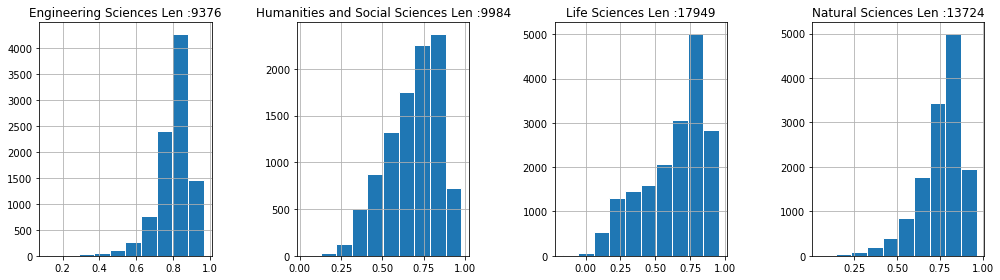

In [47]:
i=1
plt.figure(figsize=(14, 4))
for cc,w in merged_df1.groupby(['Category']):
    plt.subplot(1,4,i)
    w['Similarity'].hist( edgecolor='white', linewidth=1)    
    plt.title(str(cc)+' Len :'+str(len(w)))
    i=i+1
plt.tight_layout()

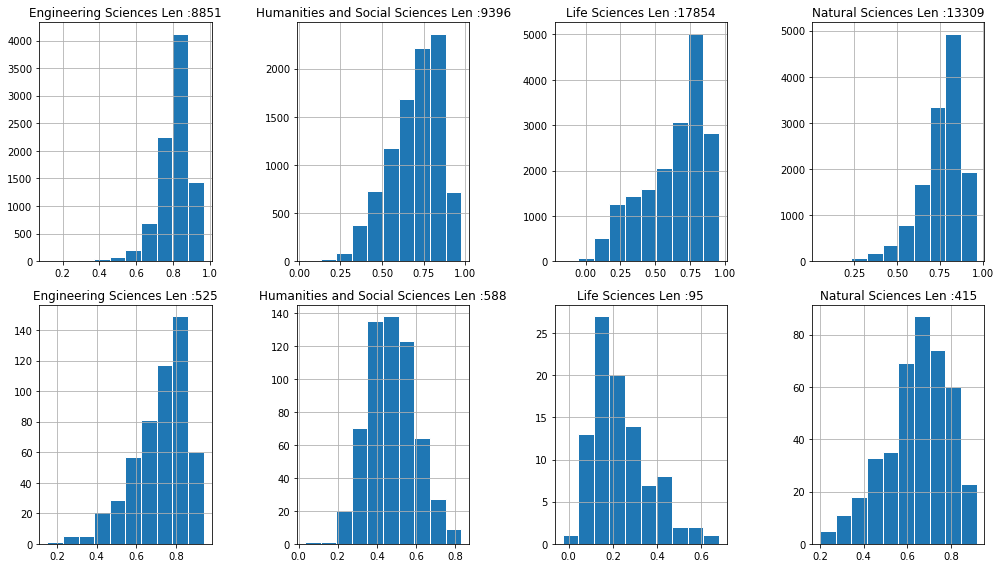

In [48]:
i=1
plt.figure(figsize=(14, 8))
for (intt,cc),w in merged_df1.groupby(['interdiscipilinary','Category']):
    plt.subplot(2,4,i)
    w['Similarity'].hist( edgecolor='white', linewidth=1)    
    plt.title(str(cc)+' Len :'+str(len(w)))
    i=i+1
plt.tight_layout()

In [75]:
#limit_cat={'Natural Sciences':.64, 'Humanities and Social Sciences':.58,'Engineering Sciences':0.815, 'Life Sciences':.45}
limit_cat={'Natural Sciences': 0.6113924050632911,
 'Humanities and Social Sciences': 0.520886075949367,
 'Engineering Sciences': 0.7348101265822784,
 'Life Sciences': 0.26582278481012656}

merged_df1['new_interdiscipilinary']=False

merged_df1.loc[(merged_df1.Category=='Natural Sciences') & (limit_cat['Natural Sciences'] > merged_df1.Similarity)
| (merged_df1.Category=='Humanities and Social Sciences') & (limit_cat['Humanities and Social Sciences'] > merged_df1.Similarity)
| (merged_df1.Category=='Engineering Sciences') & (limit_cat['Engineering Sciences'] > merged_df1.Similarity)
| (merged_df1.Category=='Life Sciences') & (limit_cat['Life Sciences'] > merged_df1.Similarity),'new_interdiscipilinary']=True

In [76]:
merged_df1[(merged_df1['new_interdiscipilinary'])].Category.value_counts()

Humanities and Social Sciences    1737
Natural Sciences                  1702
Life Sciences                     1701
Engineering Sciences              1669
Name: Category, dtype: int64

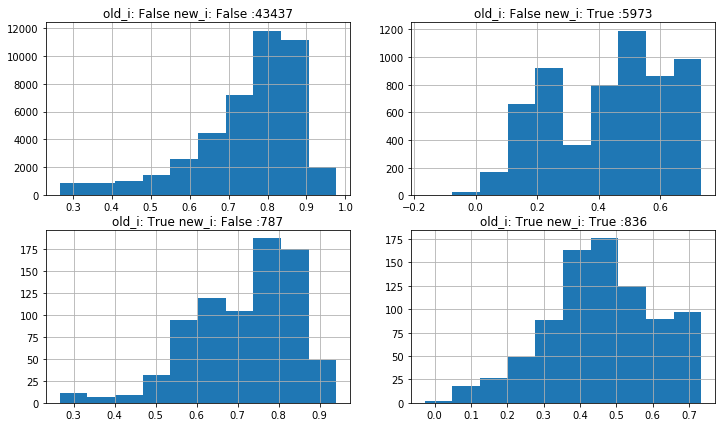

In [77]:
j=1
plt.figure(figsize=(12, 7))
for (old_i,new_i),w in merged_df1.groupby(['interdiscipilinary','new_interdiscipilinary']):
    plt.subplot(2,2,j)
    w['Similarity'].hist()
    plt.title('old_i: '+str(old_i)+' new_i: '+str(new_i)+' :'+str(len(w)) )
    j=j+1

In [78]:
merged_df1['new_interdiscipilinary'].value_counts()

False    44224
True      6809
Name: new_interdiscipilinary, dtype: int64

In [79]:
merged_df1[(merged_df1['new_interdiscipilinary']) & (merged_df1['interdiscipilinary']==False) & (merged_df1['Category']=='Life Sciences')].head(10)

,Name,SubUrl,FundingFrom,FundingEnd,SubjectArea,Institution,Description,Translates,Name_Translated,PreProcessedDescription,File_Categories,Category,direct_score,ProjectURL,Topic,Top_Category,Desc_words,Similarity,interdiscipilinary,new_interdiscipilinary
86,GRK 642:&nbsp; Valuation and Management of Bio...,/gepris/projekt/273169,2000,2003,"Agriculture, Forestry and Veterinary Medicine",Georg-August-Universität Göttingen,The goal of the interdisciplinary research tra...,The goal of the interdisciplinary research tra...,GRK 642:&nbsp; Valuation and Management of Bio...,interdisciplinary identify problem perspective...,"Agriculture, Forestry and Veterinary Medicine",Life Sciences,0.220815,https://gepris.dfg.de/gepris/projekt/273169,11,Humanities and Social Sciences,emphasis main problem social training point re...,0.194284,False,True
102,GRK 721:&nbsp; Evolution and Biodiversity in S...,/gepris/projekt/273327,2002,2004,Fundamental Biological and Medical Research,Rheinische Friedrich-Wilhelms-Universität Bonn,Although every single organism of the biospher...,Although every single organism of the biospher...,GRK 721:&nbsp; Evolution and Biodiversity in S...,single organism shape enormous associate organ...,Fundamental Biological and Medical Research,Life Sciences,0.349225,https://gepris.dfg.de/gepris/projekt/273327,29,Humanities and Social Sciences,progress aspect deal historical relate single ...,0.233650,False,True
114,GRK 778:&nbsp; Cognitive Neurobiology,/gepris/projekt/273435,2002,2005,Medicine,Eberhard Karls Universität Tübingen,The research training group 'Cognitive Neurobi...,The research training group 'Cognitive Neurobi...,GRK 778:&nbsp; Cognitive Neurobiology,cognitive neurobiology neurobiology cognition ...,Medicine,Life Sciences,0.416220,https://gepris.dfg.de/gepris/projekt/273435,4,Life Sciences,theory problem training concern neural value a...,0.189668,False,True
155,GRK 1070:&nbsp; Modelling Material Flows and P...,/gepris/projekt/425187,2004,2013,"Agriculture, Forestry and Veterinary Medicine",Universität Hohenheim,Agricultural food production in the North Chin...,Agricultural food production in the North Chin...,GRK 1070:&nbsp; Modelling Material Flows and P...,agricultural food production north china plain...,"Agriculture, Forestry and Veterinary Medicine",Life Sciences,0.197183,https://gepris.dfg.de/gepris/projekt/425187,23,Natural Sciences,consequence population problem standard meet e...,0.235815,False,True
157,GRK 1086:&nbsp; The Role of Biodiversity für B...,/gepris/projekt/446768,2005,2014,Plant Sciences,Georg-August-Universität Göttingen,The relationship between biodiversity and prod...,The relationship between biodiversity and prod...,GRK 1086:&nbsp; The Role of Biodiversity für B...,relationship biodiversity productivity biogeoc...,Plant Sciences,Life Sciences,0.304655,https://gepris.dfg.de/gepris/projekt/446768,23,Natural Sciences,consequence european relation great relationsh...,0.112158,False,True
195,Untersuchungen zum Verhalten von Mastkaninchen...,/gepris/projekt/4981130,1992,2002,"Animal Husbandry, Breeding and Hygiene",Universität Hohenheim,In den vorherigen Untersuchungen haben Kaninch...,"In previous studies, rabbits using operant con...",Studies on the behavior of rabbits under the i...,previous rabbit operant conditioning learn lev...,"Animal Husbandry, Breeding and Hygiene",Life Sciences,0.367854,https://gepris.dfg.de/gepris/projekt/4981130,14,Natural Sciences,actual thermal importance temperature meet fol...,0.137218,False,True
239,Die Kohlenstoff- und Stickstoffallokation in G...,/gepris/projekt/5076958,1997,2002,Soil Sciences,Rheinische Friedrich-Wilhelms-Universität Bonn,Pflanzen mit unterschiedlichen Ansprüchen an d...,Plants with different demands on the nutrient ...,The carbon and nitrogen allocation in grasses ...,plant demand nutrient level environment growth...,Soil Sciences,Life Sciences,0.372567,https://gepris.dfg.de/gepris/projekt/5076958,23,Natural Sciences,training overall pri

In [80]:
merged_df1[(merged_df1['new_interdiscipilinary']) & (merged_df1['interdiscipilinary']==False) & (merged_df1['Category']=='Life Sciences')].head(10).Translates.tolist()

["The goal of the interdisciplinary research training group is to identify the problems and perspectives of implementation of the biodiversity treaty. The field of research concentrates on areas of conservancy noted in Art. 8 of the treaty. The main starting point is the so-called 'reconciliation of interests' problem describing the phenomenon that costs and benefits for maintaining biodiversity are distributed unequally. Thus, it is necessary for the respective instruments to be developed for just compensation. This dilemma defines the interdisciplinary problem for the research training group and implies its primarily social science orientation.The program of study is tailored to a large degree to the demands of the above mentioned complex of topics. In addition to expanding the intradisciplinary competence of the students, it is especially important to foster the essential to work interdisciplinarily in the scientific and politically relevant area of sustainable development. The comm

In [81]:
merged_df1[(merged_df1['new_interdiscipilinary']) & (merged_df1['interdiscipilinary']==False) & (merged_df1['Category']=='Life Sciences')].head(10).PreProcessedDescription.tolist()

['interdisciplinary identify problem perspective implementation biodiversity treaty field concentrate area conservancy art treaty main point reconciliation interest problem describe phenomenon cost benefit biodiversity distribute respective compensation dilemma interdisciplinary problem training social orientation tailor large degree demand mention complex addition intradisciplinary competence student important foster essential relevant area sustainable commitment treaty educate expert area fulfil form instruction emphasis place element interdisciplinary problem solve train',
 'single organism shape enormous associate organismic evolution relevance evolution unrecognized world view act large scale progress specialisation method deal evolution modern evolutionary matter variety diverge strong training evolution biodiversity space connect aspect evolutionary biology participate field zoology botany molecular developmental biology concern organism palaeontology historical evolution interd

In [82]:
merged_df1[(merged_df1['new_interdiscipilinary']) & (merged_df1['interdiscipilinary']==False) & (merged_df1['Category']=='Life Sciences')].head(10).Desc_words.tolist()

['emphasis main problem social training point relevant essential place student identify mention phenomenon degree solve expert demand benefit element perspective respective cost implementation orientation distribute tailor',
 'progress aspect deal historical relate single training concern modern essential overall variety organism student insight view biology broad picture scale relevance strong matter collaboration developmental evolution education space world associate connect shape methodology evolutionary',
 'theory problem training concern neural value ability behavior student underlie perception evolution number industrial comparative animal specie language cognitive adaptive ideal memory',
 'consequence population problem standard meet environmental water rise production yield account soil degradation intensity food availability north',
 'consequence european relation great relationship ecological broad current ecosystem need scale understand diversity depth conduct specie cycle 

In [57]:
m=0
topicWord=merged_df1[(merged_df1['new_interdiscipilinary']) & (merged_df1['interdiscipilinary']==False) & (merged_df1['Category']=='Life Sciences')].head(10).Desc_words.tolist()[m]
print(topicWord)
for j in CategoryImpoWords.Category:
    CatWords=CategoryImpoWords[CategoryImpoWords.Category==j].Words.values[0]
    score=similarity_scores(topicWord, CatWords,30)
    print(j, score)

knowledge aspect discipline integration training signal theoretical traditional context biological cascade complexity evaluate flow meet operation organism student
Engineering Sciences 0.7581619569011995
Humanities and Social Sciences 0.5599895452612574
Life Sciences 0.42267505229366026
Natural Sciences 0.5272667913686755


## LDA Probablity based finding category

In [58]:
topic_df=pd.DataFrame(build_topics_sentences(lda_model_tfidf,corpus_tfidf))

In [59]:
merged_topic_df=topic_df.merge(TopicDesc,how='left', left_on=0, right_on='TopicNo')[[0, 1, 2, 3, 'topic_words','Category_1','Category_2']]
merged_topic_df=merged_topic_df.merge(TopicDesc,how='left', left_on=2, right_on='TopicNo')[[0, 1, 2, 3, 'topic_words_x','Category_1_x','Category_2_x','topic_words_y','Category_1_y','Category_2_y']]
merged_topic_df.columns=['Topic_1', 'Perc_cont_1', 'Topic_2', 'Perc_cont_2', 'important_topic_words_1','Category_1_1','Category_1_2', 'important_topic_words_2','Category_2_1','Category_2_2']
merged_topic_df=merged_topic_df.reset_index()[merged_topic_df.columns]

merged_df=pd.concat([df,merged_topic_df],ignore_index=True, axis=1)
merged_df.columns=df.columns.tolist()+merged_topic_df.columns.tolist()

In [60]:
merged_df['ProjectURL']=merged_df.SubUrl.apply(lambda x:'https://gepris.dfg.de'+x)

merged_df=merged_df.merge(dbdf[['ProjectURL','interdiscipilinary']],how='left', left_on='ProjectURL', right_on='ProjectURL')

In [61]:
merged_df['new_interdiscipilinary']=merged_df.apply(lambda x : x['Category']!=x['Category_1_1'],axis=1)

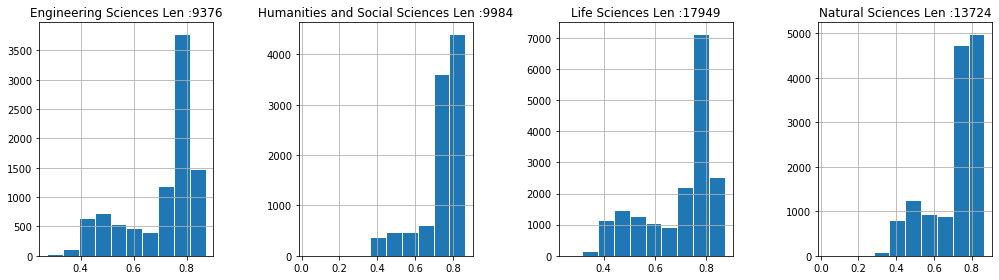

In [62]:
i=1
plt.figure(figsize=(14, 4))
for cc,w in merged_df.groupby(['Category']):
    plt.subplot(1,4,i)
    w['Perc_cont_1'].hist( edgecolor='white', linewidth=1)    
    plt.title(str(cc)+' Len :'+str(len(w)))
    i=i+1
plt.tight_layout()

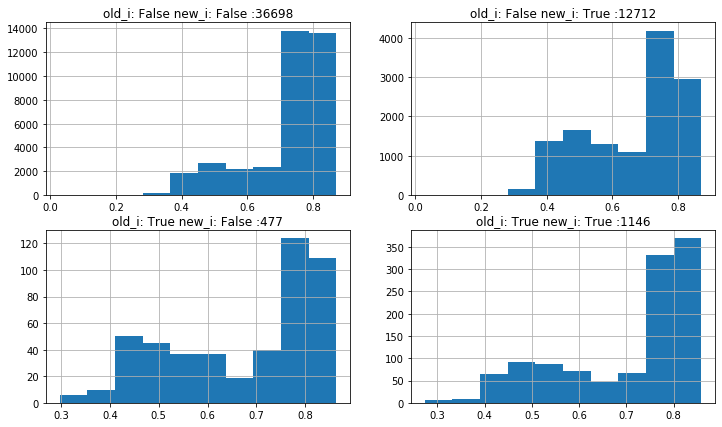

In [63]:
j=1
plt.figure(figsize=(12, 7))
for (old_i,new_i),w in merged_df.groupby(['interdiscipilinary','new_interdiscipilinary']):
    plt.subplot(2,2,j)
    w['Perc_cont_1'].hist()
    plt.title('old_i: '+str(old_i)+' new_i: '+str(new_i)+' :'+str(len(w)) )
    j=j+1

In [64]:
merged_df[(merged_df['new_interdiscipilinary']==True) & (merged_df1['Category']=='Humanities and Social Sciences')].head(10)

,Name,SubUrl,FundingFrom,FundingEnd,SubjectArea,Institution,Description,Translates,Name_Translated,PreProcessedDescription,...,Topic_2,Perc_cont_2,important_topic_words_1,Category_1_1,Category_1_2,important_topic_words_2,Category_2_1,Category_2_2,interdiscipilinary,new_interdiscipilinary
134,"GRK 884:&nbsp; Group Focused Enmity: Causes, P...",/gepris/projekt/273603,2004,2012,Psychology,Philipps-Universität Marburg,The Research Training Group examines the preva...,The Research Training Group examines the preva...,"GRK 884:&nbsp; Group Focused Enmity: Causes, P...",examine prevalence manifestation cause consequ...,...,11.0,0.230166,"gene, expression, plant, transcription, mutant...",Life Sciences,,"social, policy, market, economic, decision, po...",Humanities and Social Sciences,,False,True
144,GRK 1032:&nbsp; Statistical Modelling,/gepris/projekt/374400,2004,2013,Economics,Technische Universität Dortmund,The project fosters research in 'Statistical M...,The project fosters research in 'Statistical M...,GRK 1032:&nbsp; Statistical Modelling,statistical interface theory practice field st...,...,NaN,NaN,"theory, problem, equation, space, solution, nu...",Engineering Sciences,,NaN,NaN,NaN,False,True
172,GRK 1182:&nbsp; Function of Attention in Cogni...,/gepris/projekt/818604,2005,2014,Psychology,Universität Leipzig,The Research Training Group aims to investigat...,The Research Training Group aims to investigat...,GRK 1182:&nbsp; Function of Attention in Cogni...,role attention cognitive function perception i...,...,26.0,0.243204,"brain, memory, cognitive, neural, visual, stim...",Life Sciences,,"history, century, historical, cultural, langua...",Humanities and Social Sciences,,False,True
178,GRK 1223:&nbsp; Feedback Based Quality Managem...,/gepris/projekt/949791,2006,2010,Psychology,Technische Universität Darmstadt,E-Learning is characterised by a large gap bet...,E-Learning is characterised by a large gap bet...,GRK 1223:&nbsp; Feedback Based Quality Managem...,characterise large gap promise unsatisfactory ...,...,NaN,NaN,"tool, machine, simulation, load, parameter, pr...",Engineering Sciences,,NaN,NaN,NaN,False,True
202,Kommentar zur (Lieder-)Edda,/gepris/projekt/5026167,1992,2013,Medieval German Literature,NaN,[] Von den sechs Bänden des neuen Gesamtkommen...,[] Of the six volumes of the new complete comm...,Comment to the (song) Edda,commentary page götterlieder vol heldenlieder ...,...,13.0,0.139137,"theory, problem, equation, space, solution, nu...",Engineering Sciences,,"collection, library, online, user, publication...",Humanities and Social Sciences,,False,True
241,Untersuchung der Beziehungen zwischen Arbeitsb...,/gepris/projekt/5077330,1997,2002,"Differential Psychology, Clinical Psychology, ...",Martin-Luther-Universität Halle-Wittenberg,Die These des 'carryover-effects' Pickering (1...,The thesis of the carryover effects Pickering ...,"Examining the relationships between workload, ...",thesis carryover psychophysiological activatio...,...,NaN,NaN,"mouse, disease, receptor, inflammatory, inflam...",Life Sciences,,NaN,NaN,NaN,False,True
274,Probabilistisches und sensomotorisches Lernen ...,/gepris/projekt/5081281,1997,2002,"General, Biological and Mathematical Psychology",Rheinische Friedrich-Wilhelms-Universität Bonn,Viele assoziative Lernprozesse geschehen impli...,Many associative learning processes happen imp...,Probabilistic and sensorimotor learning in pat...,associative learn involvement declarative memo...,...,NaN,NaN,"brain, memory, cognitive, neural, visual, stim...",Life Sciences,,NaN,NaN,NaN,False,True
331,Mehrdimensionale Testmodelle und deren Anwendu...,/gepris/projekt/5086062,1997,2001,"General, Biological and Mathematical Psychology",Christian-Albrechts-Universität zu Kiel,Mit der Entwicklung mehrdimensionaler Rasch-Mo...,The work groups around Mark Wilson (Berkeley a...,Multidimensional test models and their applica...,wilson berkeley acer eiji muraki norman multid...,...,NaN,NaN,"theory, problem, equat

In [65]:
merged_df[(merged_df['new_interdiscipilinary']==True) & (merged_df1['Category']=='Humanities and Social Sciences')].head(10).Translates.tolist()

["The Research Training Group examines the prevalence, manifestations, causes and consequences of 'Group-focused enmity (GFE)'. GFE is targeted against 'alien' groups such as immigrants and Jews as well as 'norm-violating' groups such as homosexuals, handicapped or homeless. GFE manifests itself in discrimination, rejection and possibly violent behaviour directed against members of these groups. ",
 "The project fosters research in 'Statistical Modelling', an interface between theory and practice as well as in different fields of applications of statistics (for instance biometrics, econometrics). Work in the project is divided into four research areas: survey of data for statistical modelling, basics for statistical modelling, empirical modelling, algorithms in statistical modelling. Interaction among these fields is the main focus of the project. ",
 'The Research Training Group aims to investigate the role of attention in higher cognitive function, beyond perception. In an interdisci

In [66]:
for (t1,c11,c12),w in merged_df.groupby(['Topic_1','Category_1_1','Category_1_2']):
    print(t1,c11,c12)
    print(w.Category.value_counts())

0.0 Natural Sciences 
Natural Sciences                  3086
Engineering Sciences               395
Life Sciences                      146
Humanities and Social Sciences       3
Name: Category, dtype: int64
2.0 Natural Sciences Engineering Sciences
Life Sciences                     2
Natural Sciences                  1
Humanities and Social Sciences    1
Name: Category, dtype: int64
3.0 Life Sciences 
Life Sciences                     1401
Natural Sciences                   161
Engineering Sciences                35
Humanities and Social Sciences       6
Name: Category, dtype: int64
4.0 Life Sciences 
Life Sciences                     1323
Humanities and Social Sciences     956
Engineering Sciences               141
Natural Sciences                    37
Name: Category, dtype: int64
5.0 Life Sciences 
Life Sciences                     3723
Engineering Sciences                24
Humanities and Social Sciences      18
Natural Sciences                    18
Name: Category, dtype: int64
6.

In [67]:
merged_df[['SubjectArea', 'File_Categories','Category', 'Topic_1',
       'Perc_cont_1', 'Topic_2', 'Perc_cont_2','Category_1_1','Category_1_2','Category_2_1','Category_2_2']].head()

,SubjectArea,File_Categories,Category,Topic_1,Perc_cont_1,Topic_2,Perc_cont_2,Category_1_1,Category_1_2,Category_2_1,Category_2_2
0,Mathematics,Mathematics,Natural Sciences,26.0,0.762473,NaN,NaN,Humanities and Social Sciences,,NaN,NaN
1,Social Sciences,Social Sciences,Humanities and Social Sciences,11.0,0.679380,12.0,0.115359,Humanities and Social Sciences,,Humanities and Social Sciences,
2,Production Technology,Production Technology,Engineering Sciences,10.0,0.637332,9.0,0.179883,Engineering Sciences,,Natural Sciences,
3,Condensed Matter Physics,Condensed Matter Physics,Natural Sciences,24.0,0.782858,NaN,NaN,Engineering Sciences,,NaN,NaN
4,Construction Engineering and Architecture,Construction Engineering and Architecture,Engineering Sciences,20.0,0.715029,34.0,0.130507,Engineering Sciences,,Natural Sciences,


## Combining all above methodology

In [68]:
FinalMerged=merged_df.merge(merged_df1[['ProjectURL','Desc_words','Similarity','new_interdiscipilinary']],how='left', left_on='ProjectURL', right_on='ProjectURL', suffixes=('_prob', '_dist'))

In [69]:
FinalMerged=FinalMerged.merge(df1[['ProjectURL','new_interdiscipilinary','direct_score']],how='left', left_on='ProjectURL', right_on='ProjectURL', suffixes=('', '_all'))
FinalMerged['new_interdiscipilinary_all']=FinalMerged['new_interdiscipilinary']

## Distance Determiner

#### uncomment and run it only when you required to find the similarity distance

In [93]:
## uncomment and run it only when you required to find the similarity distance

FinalMerged['similarity_mean']=FinalMerged.apply(lambda x:((x['direct_score'])+x['Similarity'])/2, axis=1)
#FinalMerged['similarity_mean']=FinalMerged.apply(lambda x:x['direct_score'], axis=1)
#
#params=[]
#accuracies=[]
#precisions=[]
#recalls=[]
#categories=[]
#categories_score=[]
#volume=[]
#
#scores=np.linspace(.2,.85,80)
#limit_cat={'Natural Sciences':.4, 'Humanities and Social Sciences':.4,'Engineering Sciences':0.4, 'Life Sciences':.4}
#
#for cc in FinalMerged.Category.unique():
#    for score in scores:
#        score_volume=len(FinalMerged.loc[(FinalMerged.Category==cc) & (score > FinalMerged['similarity_mean'])])
#        ## if too small or too big, then skip it
#        if((score_volume<100) or (score_volume>1800)):
#            continue
#        limit_cat[cc]=score
#        
#        FinalMerged['new_interdiscipilinary']=False
#
#        FinalMerged.loc[(FinalMerged.Category=='Natural Sciences') & (limit_cat['Natural Sciences'] > FinalMerged.similarity_mean)
#        | (FinalMerged.Category=='Humanities and Social Sciences') & (limit_cat['Humanities and Social Sciences'] > FinalMerged.similarity_mean)
#        | (FinalMerged.Category=='Engineering Sciences') & (limit_cat['Engineering Sciences'] > FinalMerged.similarity_mean)
#        | (FinalMerged.Category=='Life Sciences') & (limit_cat['Life Sciences'] > FinalMerged.similarity_mean),'new_interdiscipilinary']=True
#        
#        actual=FinalMerged['interdiscipilinary']
#        pred=FinalMerged['new_interdiscipilinary']
#        
#        params.append(limit_cat)
#        categories.append(cc)
#        categories_score.append(score)
#        volume.append(score_volume)
#        accuracies.append(round(metrics.accuracy_score(actual,pred),4))
#        precisions.append(round(metrics.precision_score(actual,pred, average='macro'),4))
#        recalls.append(round(metrics.recall_score(actual,pred, average='macro'),4))
#calculated_metrics=pd.DataFrame({'params':params,'categories':categories,'categories_score':categories_score,'volume':volume,'accuracies':accuracies,'precisions':precisions,'recalls':recalls})
#calculated_metrics.sort_values(by='accuracies',ascending=False).head(1).params.values[0]

In [94]:
FinalMerged['new_interdiscipilinary']=False
FinalMerged.loc[((FinalMerged['new_interdiscipilinary_prob']==True) & (FinalMerged['new_interdiscipilinary_dist']==True) & (FinalMerged['new_interdiscipilinary_all']==True)), 'new_interdiscipilinary']=True

In [95]:
#FinalMerged['new_interdiscipilinary'].value_counts()
FinalMerged[(FinalMerged['new_interdiscipilinary'])].Category.value_counts()

Life Sciences                     1670
Humanities and Social Sciences    1246
Engineering Sciences              1049
Natural Sciences                   843
Name: Category, dtype: int64

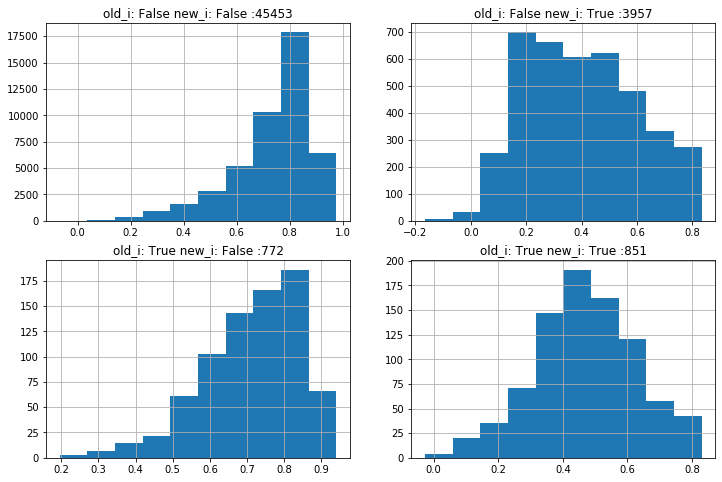

In [96]:
j=1
plt.figure(figsize=(12, 8))
for (old_i,new_i),w in FinalMerged.groupby(['interdiscipilinary','new_interdiscipilinary']):
    plt.subplot(2,2,j)
    #w['Perc_cont_1'].hist()
    w['Similarity'].hist()
    plt.title('old_i: '+str(old_i)+' new_i: '+str(new_i)+' :'+str(len(w)) )
    j=j+1

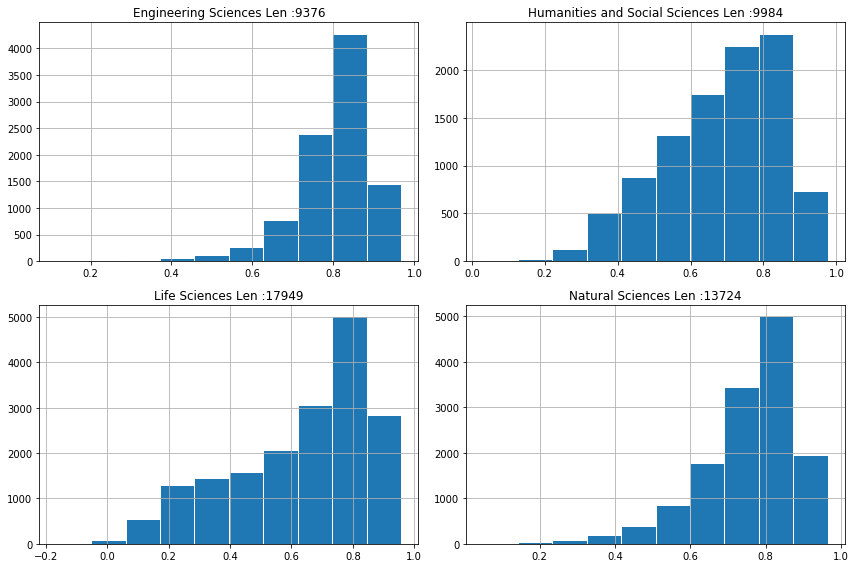

In [97]:
i=1
plt.figure(figsize=(12, 8))
for cc,w in FinalMerged.groupby(['Category']):
    plt.subplot(2,2,i)
    w['Similarity'].hist( edgecolor='white', linewidth=1)    
    plt.title(str(cc)+' Len :'+str(len(w)))
    i=i+1
plt.tight_layout()

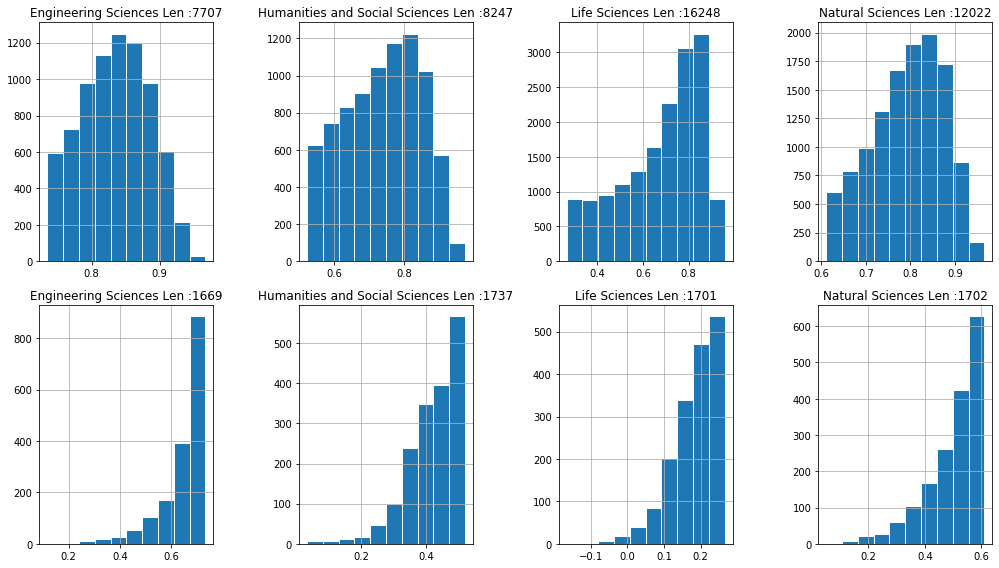

In [98]:
i=1
plt.figure(figsize=(14, 8))
for (intt,cc),w in merged_df1.groupby(['new_interdiscipilinary','Category']):
    plt.subplot(2,4,i)
    w['Similarity'].hist( edgecolor='white', linewidth=1)    
    plt.title(str(cc)+' Len :'+str(len(w)))
    i=i+1
plt.tight_layout()

In [99]:
FinalMerged[(FinalMerged['new_interdiscipilinary']) & (FinalMerged['interdiscipilinary']==False) & (FinalMerged['Category']=='Life Sciences')].head(10)

,Name,SubUrl,FundingFrom,FundingEnd,SubjectArea,Institution,Description,Translates,Name_Translated,PreProcessedDescription,...,Category_2_2,interdiscipilinary,new_interdiscipilinary_prob,Desc_words,Similarity,new_interdiscipilinary_dist,new_interdiscipilinary,direct_score_all,new_interdiscipilinary_all,similarity_mean
86,GRK 642:&nbsp; Valuation and Management of Bio...,/gepris/projekt/273169,2000,2003,"Agriculture, Forestry and Veterinary Medicine",Georg-August-Universität Göttingen,The goal of the interdisciplinary research tra...,The goal of the interdisciplinary research tra...,GRK 642:&nbsp; Valuation and Management of Bio...,interdisciplinary identify problem perspective...,...,,False,True,emphasis main problem social training point re...,0.194284,True,True,0.220815,True,0.207550
102,GRK 721:&nbsp; Evolution and Biodiversity in S...,/gepris/projekt/273327,2002,2004,Fundamental Biological and Medical Research,Rheinische Friedrich-Wilhelms-Universität Bonn,Although every single organism of the biospher...,Although every single organism of the biospher...,GRK 721:&nbsp; Evolution and Biodiversity in S...,single organism shape enormous associate organ...,...,,False,True,progress aspect deal historical relate single ...,0.233650,True,True,0.349225,True,0.291437
119,GRK 793:&nbsp; Epidemiology of Communicable an...,/gepris/projekt/273475,2002,2011,Medicine,Ruprecht-Karls-Universität Heidelberg,Large epidemiological studies which have been ...,Large epidemiological studies which have been ...,GRK 793:&nbsp; Epidemiology of Communicable an...,large epidemiological carry design population ...,...,,False,True,common population carry platform,0.365508,True,True,0.292040,True,0.328774
155,GRK 1070:&nbsp; Modelling Material Flows and P...,/gepris/projekt/425187,2004,2013,"Agriculture, Forestry and Veterinary Medicine",Universität Hohenheim,Agricultural food production in the North Chin...,Agricultural food production in the North Chin...,GRK 1070:&nbsp; Modelling Material Flows and P...,agricultural food production north china plain...,...,,False,True,consequence population problem standard meet e...,0.235815,True,True,0.197183,True,0.216499
157,GRK 1086:&nbsp; The Role of Biodiversity für B...,/gepris/projekt/446768,2005,2014,Plant Sciences,Georg-August-Universität Göttingen,The relationship between biodiversity and prod...,The relationship between biodiversity and prod...,GRK 1086:&nbsp; The Role of Biodiversity für B...,relationship biodiversity productivity biogeoc...,...,NaN,False,True,consequence european relation great relationsh...,0.112158,True,True,0.304655,True,0.208407
158,GRK 1091:&nbsp; Orientation and Motion in Space,/gepris/projekt/449590,2005,2014,Neurosciences,Ludwig-Maximilians-Universität München,The Research Training Group for system-oriente...,The Research Training Group for system-oriente...,GRK 1091:&nbsp; Orientation and Motion in Space,orient neurobiology discipline faculty ludwig ...,...,,False,True,discipline member training orient engineering ...,0.404170,True,True,0.347927,True,0.376048
195,Untersuchungen zum Verhalten von Mastkaninchen...,/gepris/projekt/4981130,1992,2002,"Animal Husbandry, Breeding and Hygiene",Universität Hohenheim,In den vorherigen Untersuchungen haben Kaninch...,"In previous studies, rabbits using operant con...",Studies on the behavior of rabbits under the i...,previous rabbit operant conditioning learn lev...,...,,False,True,actual thermal importance temperature meet fol...,0.137218,True,True,0.367854,True,0.252536
196,"Bestimmung der Struktur, Dynamik und Wechselwi...",/gepris/projekt/4992156,1992,2002,Biophysics,University of Strasbourg/CNRS,Unser Ziel sind die Strukturaufklärung der C-t...,Our goal is to elucidate the structure of the ...,"Determination of the structure, dynamics and i...",elucidate structure terminal ion channel colic...,...,NaN,False,True,fragment measure short solution fundamental so...,0.299387,True,True,0.369306,True,0.334346
239,Die Kohlenstoff- und Stick

In [100]:
FinalMerged[(FinalMerged['new_interdiscipilinary']) & (FinalMerged['interdiscipilinary']==False) & (FinalMerged['Category']=='Life Sciences')].head(10).Translates.tolist()

["The goal of the interdisciplinary research training group is to identify the problems and perspectives of implementation of the biodiversity treaty. The field of research concentrates on areas of conservancy noted in Art. 8 of the treaty. The main starting point is the so-called 'reconciliation of interests' problem describing the phenomenon that costs and benefits for maintaining biodiversity are distributed unequally. Thus, it is necessary for the respective instruments to be developed for just compensation. This dilemma defines the interdisciplinary problem for the research training group and implies its primarily social science orientation.The program of study is tailored to a large degree to the demands of the above mentioned complex of topics. In addition to expanding the intradisciplinary competence of the students, it is especially important to foster the essential to work interdisciplinarily in the scientific and politically relevant area of sustainable development. The comm

In [101]:
FinalMerged[(FinalMerged['new_interdiscipilinary']) & (FinalMerged['interdiscipilinary']==False) & (FinalMerged['Category']=='Life Sciences')].head(10).Desc_words.tolist()

['emphasis main problem social training point relevant essential place student identify mention phenomenon degree solve expert demand benefit element perspective respective cost implementation orientation distribute tailor',
 'progress aspect deal historical relate single training concern modern essential overall variety organism student insight view biology broad picture scale relevance strong matter collaboration developmental evolution education space world associate connect shape methodology evolutionary',
 'common population carry platform',
 'consequence population problem standard meet environmental water rise production yield account soil degradation intensity food availability north',
 'consequence european relation great relationship ecological broad current ecosystem need scale understand diversity depth conduct specie cycle service conversion mixed good',
 'discipline member training orient engineering student clinical medicine biology education optimal language',
 'actual 

In [102]:
FinalMerged.to_csv(Path+'LDA_Distance_Exp2.csv', index=False)

In [103]:
def CattoID(input_cat):
    if(input_cat=='Engineering Sciences') :
        return 0
    elif(input_cat=='Humanities and Social Sciences') :
        return 1
    elif(input_cat=='Natural Sciences') :
        return 2
    elif(input_cat=='Life Sciences') :
        return 3
    else :
        return -1

In [166]:
DescDictforpca=[[x for x in str(i).split()] for i in FinalMerged.Desc_words]

tagged_valueforpca = list(create_tagged_document(DescDictforpca))

modelforpca = gensim.models.doc2vec.Doc2Vec(vector_size=2, min_count=5, epochs=40, alpha = 0.02, dm=1, workers=4)

# Build the Volabulary
modelforpca.build_vocab(tagged_valueforpca)
modelforpca.train(tagged_valueforpca, total_examples=len(tagged_valueforpca), epochs=40)


In [167]:
new_features=pd.concat([pd.DataFrame(modelforpca.docvecs.vectors_docs),FinalMerged[['Similarity','similarity_mean','Perc_cont_1' ]]], axis=1,ignore_index=False)
cols=new_features.columns

In [168]:
## PCA - reducing the dimenstion
pcamodel = PCA(n_components=2)
pca=pcamodel.fit_transform(new_features)

print('PCA components :',2,'Variance coveragence' ,np.max(pcamodel.explained_variance_ratio_.cumsum())*100)

PCA components : 2 Variance coveragence 89.69554455370996


In [187]:
FinalMerged['new_interdiscipilinary_prob0']=FinalMerged.new_interdiscipilinary_prob.astype(int)
FinalMerged['new_interdiscipilinary_dist0']=FinalMerged.new_interdiscipilinary_dist.astype(int)
FinalMerged['new_interdiscipilinary_all0']=FinalMerged.new_interdiscipilinary_all.astype(int)
FinalMerged['new_interdiscipilinary0']=FinalMerged.new_interdiscipilinary.astype(int)

#FinalMerged.loc[((FinalMerged['new_interdiscipilinary_prob']==True) & (FinalMerged['new_interdiscipilinary_dist']==True) & (FinalMerged['new_interdiscipilinary_all']==True)), 'new_interdiscipilinary']=True

In [188]:
#new_features=pd.concat([pd.DataFrame(modelforpca.docvecs.vectors_docs),FinalMerged[['Category','Similarity','similarity_mean','Perc_cont_1' ]]], axis=1,ignore_index=False)
new_features=FinalMerged[['Category','similarity_mean','Perc_cont_1','new_interdiscipilinary0']]
cols=['similarity_mean','Perc_cont_1','new_interdiscipilinary0']


In [189]:
#tsnedata.loc[new_features.Category==cat,'tsne-2d-one']=tsne_results[:,0]

In [190]:
tsnedata=pd.DataFrame()
tsnedata['tsne-2d-one']=0
tsnedata['tsne-2d-two']=0
tsnedata['Category']=new_features['Category']

tsne=TSNE(n_components=2, perplexity=.1,random_state=42)

#tsne=TSNE(n_components=2, perplexity=1, n_iter=300, random_state=0, learning_rate=100)
## The perplexity is related to the number of nearest neighbors that is used in other manifold learning algorithms. 
## Larger datasets usually require a larger perplexity. Consider selecting a value between 5 and 50. 

for cat in new_features.Category.unique() :
    print(str(datetime.datetime.now()),'Started for', cat)
    
    tsne_results = tsne.fit_transform(new_features[new_features.Category==cat][cols])  
    tsnedata.loc[tsnedata.Category==cat,'tsne-2d-one'] = tsne_results[:,0]
    tsnedata.loc[tsnedata.Category==cat,'tsne-2d-two'] = tsne_results[:,1]

    print(str(datetime.datetime.now()),'Completed for', cat)

2020-03-13 16:13:43.786857 Started for Natural Sciences
2020-03-13 16:16:26.720840 Completed for Natural Sciences
2020-03-13 16:16:26.721081 Started for Humanities and Social Sciences
2020-03-13 16:18:23.970649 Completed for Humanities and Social Sciences
2020-03-13 16:18:23.970841 Started for Engineering Sciences
2020-03-13 16:20:39.146713 Completed for Engineering Sciences
2020-03-13 16:20:39.147453 Started for Life Sciences
2020-03-13 16:25:55.797848 Completed for Life Sciences


In [294]:
final_cols=['Name', 'FundingFrom', 'FundingEnd', 'SubjectArea',
       'Institution', 'PreProcessedDescription','Description', 'Translates','File_Categories', 'Category',
       'direct_score', 'Similarity','Perc_cont_1', 'ProjectURL', 'Topic_1', 'new_interdiscipilinary_dist',
        'new_interdiscipilinary_prob', 'new_interdiscipilinary', 'similarity_mean' ]
#pd.concat([FinalMerged[final_cols],pd.DataFrame(pca,columns=['PCA1','PCA2']),tsnedata[['tsne-2d-one','tsne-2d-two']]], axis=1,ignore_index=False).to_csv(Path+'LDA_Distance_Exp2.1.csv', index=False)

### Simlarity between the catergories

In [42]:
for c1 in CategoryImpoWords.Category:
    CategoryImpoWords[c1]=0
    for c2 in CategoryImpoWords.Category:
         CategoryImpoWords.loc[CategoryImpoWords.Category==c2,c1]=similarity_scores(CategoryImpoWords.loc[CategoryImpoWords.Category==c1, 'Words'].values[0],  CategoryImpoWords.loc[CategoryImpoWords.Category==c2, 'Words'].values[0]
                                                                                    ,50)
CategoryImpoWords

,Category,Words,Engineering Sciences,Humanities and Social Sciences,Life Sciences,Natural Sciences
0,Engineering Sciences,engineer method simulation component flow surf...,1.000000,0.157224,0.224229,0.723208
1,Humanities and Social Sciences,humanities social history country century poli...,0.157224,1.000000,-0.002255,0.087960
2,Life Sciences,biology life cell protein gene disease molecul...,0.224229,-0.002255,1.000000,0.189340
3,Natural Sciences,natural field surface quantum metal theory mag...,0.723208,0.087960,0.189340,1.000000


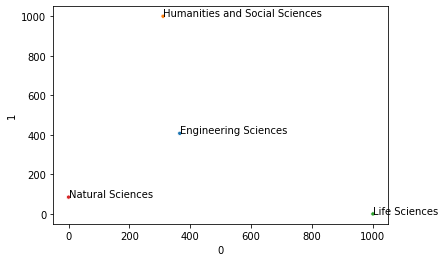

In [230]:
## Generating coordinates from distance

#, angle=0.8

#coords = TSNE(n_components=2,perplexity=.1, random_state=12, metric='precomputed').fit_transform(sym_dist)

coords = TSNE(n_components=2,perplexity=1.9, random_state=42).fit_transform(CategoryImpoWords[[ 'Engineering Sciences','Humanities and Social Sciences', 'Life Sciences', 'Natural Sciences']])
#coords = PCA(n_components=2).fit_transform(CategoryImpoWords[[ 'Engineering Sciences','Humanities and Social Sciences', 'Life Sciences', 'Natural Sciences']])

coords=MinMaxScaler([0,1000]).fit_transform(coords)
coords=pd.DataFrame(coords, index=CategoryImpoWords.Category).reset_index()
p1=sns.scatterplot(
    x=0, y=1,
    hue="Category",
 #   palette=sns.color_palette("hls", 4),
    data=coords,
   # legend="full",
    alpha=1,
    size = 8,
    legend=False
)

for line in range(0,coords.shape[0]):
     p1.text(coords[0][line]+0.01, coords[1][line], CategoryImpoWords.Category[line], horizontalalignment='left',  size='medium', color='black')

In [284]:
newrange=pd.DataFrame(FinalMerged.Category.value_counts()/120).reset_index().merge(coords,left_on='index',right_on='Category')
newrange.loc[:,'Min_X']=newrange[0]-newrange['Category_x']
newrange.loc[:,'Max_X']=newrange[0]+newrange['Category_x']
newrange.loc[:,'Min_Y']=newrange[1]-(newrange['Category_x']*.6)
newrange.loc[:,'Max_Y']=newrange[1]+(newrange['Category_x']*.6)

newrange.columns=['Category','size','Category2', 0, 1, 'Min_X', 'Max_X', 'Min_Y', 'Max_Y']
newrange=newrange[['Category','size', 0, 1, 'Min_X', 'Max_X', 'Min_Y', 'Max_Y']]
newrange

,Category,size,0,1,Min_X,Max_X,Min_Y,Max_Y
0,Life Sciences,149.575000,999.999939,0.000000,850.424939,1149.574939,-89.745000,89.745000
1,Natural Sciences,114.366667,0.000000,85.055206,-114.366667,114.366667,16.435206,153.675206
2,Humanities and Social Sciences,83.200000,310.519257,1000.000000,227.319257,393.719257,950.080000,1049.920000
3,Engineering Sciences,78.133333,365.458801,407.651337,287.325468,443.592135,360.771337,454.531337


In [295]:
# Reshaping

FinalMerged1=pd.concat([FinalMerged[final_cols],pd.DataFrame(pca,columns=['PCA1','PCA2'])], axis=1,ignore_index=False)
                        #.to_csv(Path+'LDA_Distance_Exp2.1.csv', index=False)
                
for cat in CategoryImpoWords.Category:
    model_x=MinMaxScaler([newrange[newrange['Category']==cat].Min_X.values[0],newrange[newrange['Category']==cat].Max_X.values[0]])
    FinalMerged1.loc[FinalMerged['Category']==cat,'PCA1']=model_x.fit_transform(FinalMerged1[FinalMerged1['Category']==cat][['PCA1']])

    model_y=MinMaxScaler([newrange[newrange['Category']==cat].Min_Y.values[0],newrange[newrange['Category']==cat].Max_Y.values[0]])
    FinalMerged1.loc[FinalMerged['Category']==cat,'PCA2']=model_y.fit_transform(FinalMerged1[FinalMerged1['Category']==cat][['PCA2']])


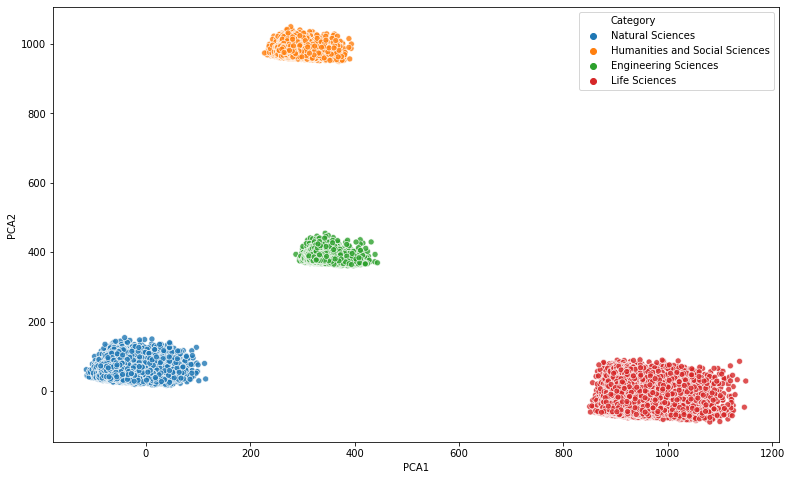

In [296]:
plt.figure(figsize=(13,8))
sns.scatterplot(
        x="PCA1", y="PCA2",
        hue="Category",
        data=FinalMerged1,
        legend="full",
        alpha=0.8
    );

In [297]:
FinalMerged1.to_csv(Path+'LDA_Distance_Exp2.1.csv', index=False)
newrange.to_csv(Path+'LDA_Range_Category.csv', index=False)